## Study of type event recognition for the PETALO experiment using ML

### Imports

In [3]:
import numpy  as np
import pandas as pd
import random

import matplotlib.pyplot as plt

In [4]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks     import ModelCheckpoint, EarlyStopping

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [5]:
phot_list, compt_list, phot_like_list = [], [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmd_images_phot_compt_and_phot_like.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
for im in data['phot_like_images']:
    if len(im)==0:
        continue
    phot_like_list.append(im.reshape(400))

compt_images     = np.array(compt_list)
phot_images      = np.array(phot_list)
phot_like_images = np.array(phot_like_list)

In [6]:
phot_images.shape

(19932, 400)

In [9]:
compt_images.shape

(25000, 400)

In [10]:
phot_like_images.shape

(25000, 400)

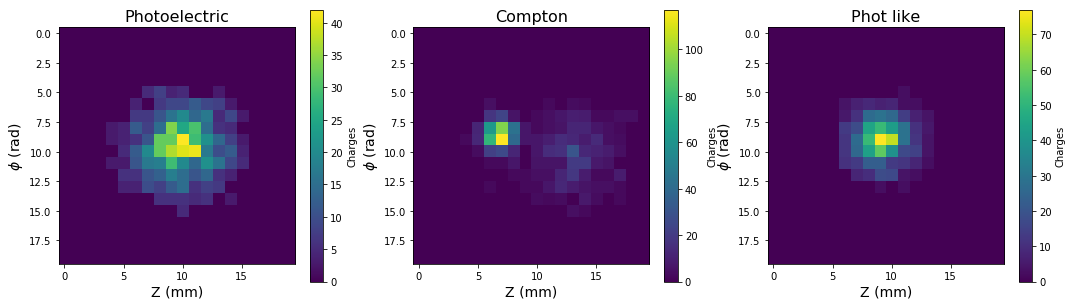

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[0].reshape(20,20))
fig3 = ax3.imshow(phot_like_images[0].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
ax3.set_xlabel('Z (mm)',       size=14)
ax3.set_ylabel('$\phi$ (rad)', size=14)
ax3.set_title('Phot like',     size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
fig.colorbar(fig3, ax=ax3, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1
- phot like:     2

In [13]:
compt_labels     =   np.zeros(len(    compt_images))
phot_labels      =   np.ones (len(     phot_images))
phot_like_labels = 2*np.ones (len(phot_like_images))

### Normalization:

In [14]:
norm_phot_images      = np.array([i/np.max(i) for i in      phot_images])
norm_compt_images     = np.array([i/np.max(i) for i in     compt_images])
norm_phot_like_images = np.array([i/np.max(i) for i in phot_like_images])

## Inputs for the CNN:

In [15]:
y = np.concatenate((compt_labels,      phot_labels,      phot_like_labels))
x = np.concatenate((norm_compt_images, norm_phot_images, norm_phot_like_images))
print(y.shape)
print(x.shape)
print(y)

(69932,)
(69932, 400)
[0. 0. 0. ... 2. 2. 2.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [16]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 

Split data in trining, validation and testing:

In [17]:
#######
train_split = 50000
#######
test_split  = 10000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [18]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(10000, 400) (10000,)
(50000, 400) (50000,)
(9932, 400) (9932,)


In [19]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
[1. 2. 2. ... 0. 0. 0.]


In [20]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(50000, 3)
(9932, 3)
(10000, 3)


50000 train samples
9932 validation samples


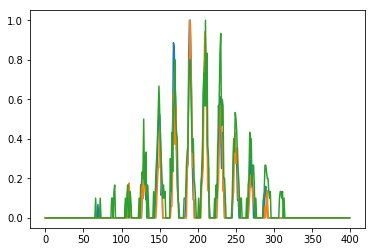

In [21]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[0])
plt.show()

Reshape data for CNN:

In [22]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
x_train_cnn.shape

(50000, 20, 20, 1)

In [23]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((2, 2))) #Max pooling operation for 2D spatial data.
cnnmodel.add(layer)
cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
#cnnmodel.add(Conv2D(128, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(3, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
dense (Dense)                (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         262400    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 256)         0

In [24]:
batch_size = 50
epochs     = 30

## To prevent it from memorizing the learning samples when the number of epochs is high

dir_path        = '/Users/carmenromoluque/machine-learning-course/'
best_model_name = dir_path + f'CNN_regression_R_{epochs}_{batch_size}.h5'
model_check     = ModelCheckpoint(best_model_name, monitor='val_sigma', verbose=1, save_best_only=True, 
                                  save_weights_only=False, mode='min', save_freq=1)
early_stop      = EarlyStopping(monitor='val_loss', min_delta=0, patience=900, 
                                verbose=1, mode='auto', baseline=None)


history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot),
                       callbacks=[model_check, early_stop])

Train on 50000 samples, validate on 9932 samples
Epoch 1/30
 2350/50000 [>.............................] - ETA: 2:04 - loss: 1.0529 - accuracy: 0.4306WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/50000 [=>............................] - ETA: 1:51 - loss: 1.0417 - accuracy: 0.4419WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/50000 [===>..........................] - ETA: 1:34 - loss: 1.0359 - accuracy: 0.4424WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/50000 [====>.........................] - ETA: 1:22 - loss: 1.0281 - accuracy: 0.4495WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/50000 [======>.......................] - ETA: 1:19 - loss: 1.0220 - accuracy: 0.4567WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/50000 [=======>......................] - ETA: 1:12 - loss: 1.0176 - accuracy: 0.4627WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/50000 [=========>....................] - ETA: 1:05 - loss: 1.0145 - accuracy: 0.4665WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/50000 [==========>...................] - ETA: 59s - loss: 1.0120 - accuracy: 0.4683WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/50000 [===========>..................] - ETA: 53s - loss: 1.0102 - accuracy: 0.4694WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/50000 [=============>................] - ETA: 48s - loss: 1.0087 - accuracy: 0.4699WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/50000 [==============>...............] - ETA: 43s - loss: 1.0065 - accuracy: 0.4713WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/50000 [================>.............] - ETA: 38s - loss: 1.0050 - accuracy: 0.4725WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/50000 [=================>............] - ETA: 34s - loss: 1.0025 - accuracy: 0.4746WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/50000 [===================>..........] - ETA: 29s - loss: 1.0013 - accuracy: 0.4758WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35950/50000 [====================>.........] - ETA: 24s - loss: 1.0007 - accuracy: 0.4754WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/50000 [======================>.......] - ETA: 20s - loss: 0.9995 - accuracy: 0.4763WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40750/50000 [=======================>......] - ETA: 16s - loss: 0.9988 - accuracy: 0.4763WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43150/50000 [========================>.....] - ETA: 11s - loss: 0.9985 - accuracy: 0.4767WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45600/50000 [==========================>...] - ETA: 7s - loss: 0.9980 - accuracy: 0.4768WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48050/50000 [===========================>..] - ETA: 3s - loss: 0.9975 - accuracy: 0.4773WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 89s 2ms/sample - loss: 0.9977 - accuracy: 0.4774 - val_loss: 0.9881 - val_accuracy: 0.4870
Epoch 2/30
  450/50000 [..............................] - ETA: 1:14 - loss: 0.9488 - accuracy: 0.5333WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2850/50000 [>.............................] - ETA: 1:10 - loss: 0.9750 - accuracy: 0.5063WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5250/50000 [==>...........................] - ETA: 1:06 - loss: 0.9786 - accuracy: 0.4939WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7650/50000 [===>..........................] - ETA: 1:02 - loss: 0.9796 - accuracy: 0.4956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10050/50000 [=====>........................] - ETA: 59s - loss: 0.9794 - accuracy: 0.4926WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12450/50000 [======>.......................] - ETA: 56s - loss: 0.9820 - accuracy: 0.4899WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14850/50000 [=======>......................] - ETA: 52s - loss: 0.9837 - accuracy: 0.4855WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17250/50000 [=========>....................] - ETA: 48s - loss: 0.9822 - accuracy: 0.4853WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19650/50000 [==========>...................] - ETA: 45s - loss: 0.9820 - accuracy: 0.4862WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22050/50000 [============>.................] - ETA: 41s - loss: 0.9817 - accuracy: 0.4864WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24450/50000 [=============>................] - ETA: 37s - loss: 0.9833 - accuracy: 0.4847WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26850/50000 [===============>..............] - ETA: 34s - loss: 0.9830 - accuracy: 0.4840WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29250/50000 [================>.............] - ETA: 30s - loss: 0.9829 - accuracy: 0.4842WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31650/50000 [=================>............] - ETA: 27s - loss: 0.9828 - accuracy: 0.4846WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34050/50000 [===================>..........] - ETA: 23s - loss: 0.9814 - accuracy: 0.4860WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36450/50000 [====================>.........] - ETA: 20s - loss: 0.9804 - accuracy: 0.4865WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38850/50000 [======================>.......] - ETA: 16s - loss: 0.9790 - accuracy: 0.4877WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41250/50000 [=======================>......] - ETA: 12s - loss: 0.9787 - accuracy: 0.4875WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43700/50000 [=========================>....] - ETA: 9s - loss: 0.9777 - accuracy: 0.4885WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46150/50000 [==========================>...] - ETA: 5s - loss: 0.9780 - accuracy: 0.4882WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48600/50000 [============================>.] - ETA: 2s - loss: 0.9776 - accuracy: 0.4892WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9779 - accuracy: 0.4885 - val_loss: 0.9696 - val_accuracy: 0.4880
Epoch 3/30
 1000/50000 [..............................] - ETA: 1:13 - loss: 0.9518 - accuracy: 0.5170WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3400/50000 [=>............................] - ETA: 1:10 - loss: 0.9705 - accuracy: 0.5053WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5800/50000 [==>...........................] - ETA: 1:06 - loss: 0.9667 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8200/50000 [===>..........................] - ETA: 1:02 - loss: 0.9622 - accuracy: 0.5051WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10600/50000 [=====>........................] - ETA: 59s - loss: 0.9637 - accuracy: 0.5045WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13000/50000 [======>.......................] - ETA: 55s - loss: 0.9672 - accuracy: 0.4996WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15400/50000 [========>.....................] - ETA: 51s - loss: 0.9687 - accuracy: 0.4971WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17800/50000 [=========>....................] - ETA: 48s - loss: 0.9695 - accuracy: 0.4961WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20200/50000 [===========>..................] - ETA: 44s - loss: 0.9710 - accuracy: 0.4931WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22600/50000 [============>.................] - ETA: 40s - loss: 0.9717 - accuracy: 0.4927WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25000/50000 [==============>...............] - ETA: 37s - loss: 0.9710 - accuracy: 0.4931WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27400/50000 [===============>..............] - ETA: 33s - loss: 0.9713 - accuracy: 0.4925WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29800/50000 [================>.............] - ETA: 29s - loss: 0.9702 - accuracy: 0.4929WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32200/50000 [==================>...........] - ETA: 26s - loss: 0.9695 - accuracy: 0.4927WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34600/50000 [===================>..........] - ETA: 22s - loss: 0.9705 - accuracy: 0.4922WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37000/50000 [=====================>........] - ETA: 19s - loss: 0.9696 - accuracy: 0.4929WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39400/50000 [======================>.......] - ETA: 15s - loss: 0.9701 - accuracy: 0.4924WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41800/50000 [========================>.....] - ETA: 12s - loss: 0.9698 - accuracy: 0.4924WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44250/50000 [=========================>....] - ETA: 8s - loss: 0.9701 - accuracy: 0.4926WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46700/50000 [===========================>..] - ETA: 4s - loss: 0.9702 - accuracy: 0.4928WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49150/50000 [============================>.] - ETA: 1s - loss: 0.9701 - accuracy: 0.4934WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 76s 2ms/sample - loss: 0.9706 - accuracy: 0.4932 - val_loss: 0.9678 - val_accuracy: 0.5046
Epoch 4/30
 1550/50000 [..............................] - ETA: 1:12 - loss: 0.9644 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3950/50000 [=>............................] - ETA: 1:09 - loss: 0.9645 - accuracy: 0.4965WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6350/50000 [==>...........................] - ETA: 1:05 - loss: 0.9669 - accuracy: 0.4910WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8750/50000 [====>.........................] - ETA: 1:01 - loss: 0.9681 - accuracy: 0.4902WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11150/50000 [=====>........................] - ETA: 58s - loss: 0.9709 - accuracy: 0.4867WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13550/50000 [=======>......................] - ETA: 54s - loss: 0.9725 - accuracy: 0.4859WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15950/50000 [========>.....................] - ETA: 51s - loss: 0.9697 - accuracy: 0.4882WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18350/50000 [==========>...................] - ETA: 47s - loss: 0.9697 - accuracy: 0.4883WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20750/50000 [===========>..................] - ETA: 43s - loss: 0.9680 - accuracy: 0.4916WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23150/50000 [============>.................] - ETA: 40s - loss: 0.9669 - accuracy: 0.4929WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25550/50000 [==============>...............] - ETA: 36s - loss: 0.9666 - accuracy: 0.4938WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27950/50000 [===============>..............] - ETA: 32s - loss: 0.9668 - accuracy: 0.4940WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30350/50000 [=================>............] - ETA: 29s - loss: 0.9662 - accuracy: 0.4950WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32750/50000 [==================>...........] - ETA: 25s - loss: 0.9651 - accuracy: 0.4953WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35150/50000 [====================>.........] - ETA: 22s - loss: 0.9645 - accuracy: 0.4954WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37550/50000 [=====================>........] - ETA: 18s - loss: 0.9651 - accuracy: 0.4944WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39950/50000 [======================>.......] - ETA: 14s - loss: 0.9653 - accuracy: 0.4947WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42350/50000 [========================>.....] - ETA: 11s - loss: 0.9647 - accuracy: 0.4950WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44800/50000 [=========================>....] - ETA: 7s - loss: 0.9650 - accuracy: 0.4942WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47250/50000 [===========================>..] - ETA: 4s - loss: 0.9650 - accuracy: 0.4944WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49700/50000 [============================>.] - ETA: 0s - loss: 0.9640 - accuracy: 0.4952WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9639 - accuracy: 0.4952 - val_loss: 0.9662 - val_accuracy: 0.5086
Epoch 5/30
 2100/50000 [>.............................] - ETA: 1:09 - loss: 0.9512 - accuracy: 0.5105WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4500/50000 [=>............................] - ETA: 1:05 - loss: 0.9573 - accuracy: 0.4982WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6900/50000 [===>..........................] - ETA: 1:02 - loss: 0.9555 - accuracy: 0.5001WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9300/50000 [====>.........................] - ETA: 58s - loss: 0.9583 - accuracy: 0.5009WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11700/50000 [======>.......................] - ETA: 55s - loss: 0.9569 - accuracy: 0.5021WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14100/50000 [=======>......................] - ETA: 51s - loss: 0.9586 - accuracy: 0.4946WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16500/50000 [========>.....................] - ETA: 48s - loss: 0.9575 - accuracy: 0.4955WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18900/50000 [==========>...................] - ETA: 44s - loss: 0.9571 - accuracy: 0.4959WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21300/50000 [===========>..................] - ETA: 41s - loss: 0.9579 - accuracy: 0.4960WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23700/50000 [=============>................] - ETA: 37s - loss: 0.9581 - accuracy: 0.4949WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26100/50000 [==============>...............] - ETA: 34s - loss: 0.9586 - accuracy: 0.4948WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28500/50000 [================>.............] - ETA: 30s - loss: 0.9594 - accuracy: 0.4937WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30900/50000 [=================>............] - ETA: 27s - loss: 0.9590 - accuracy: 0.4940WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33300/50000 [==================>...........] - ETA: 24s - loss: 0.9595 - accuracy: 0.4939WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35700/50000 [====================>.........] - ETA: 20s - loss: 0.9597 - accuracy: 0.4935WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38100/50000 [=====================>........] - ETA: 17s - loss: 0.9596 - accuracy: 0.4941WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40500/50000 [=======================>......] - ETA: 13s - loss: 0.9595 - accuracy: 0.4947WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42900/50000 [========================>.....] - ETA: 10s - loss: 0.9594 - accuracy: 0.4956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45350/50000 [==========================>...] - ETA: 6s - loss: 0.9585 - accuracy: 0.4964WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47800/50000 [===========================>..] - ETA: 3s - loss: 0.9583 - accuracy: 0.4964WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 75s 1ms/sample - loss: 0.9586 - accuracy: 0.4957 - val_loss: 0.9635 - val_accuracy: 0.5018
Epoch 6/30
  200/50000 [..............................] - ETA: 1:16 - loss: 0.9967 - accuracy: 0.4200WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2600/50000 [>.............................] - ETA: 1:10 - loss: 0.9464 - accuracy: 0.5123WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5000/50000 [==>...........................] - ETA: 1:07 - loss: 0.9482 - accuracy: 0.5106WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7400/50000 [===>..........................] - ETA: 1:05 - loss: 0.9511 - accuracy: 0.5055WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9800/50000 [====>.........................] - ETA: 1:01 - loss: 0.9492 - accuracy: 0.5089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12200/50000 [======>.......................] - ETA: 57s - loss: 0.9518 - accuracy: 0.5099WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14600/50000 [=======>......................] - ETA: 53s - loss: 0.9525 - accuracy: 0.5075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17000/50000 [=========>....................] - ETA: 50s - loss: 0.9528 - accuracy: 0.5066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19400/50000 [==========>...................] - ETA: 46s - loss: 0.9549 - accuracy: 0.5038WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21800/50000 [============>.................] - ETA: 42s - loss: 0.9553 - accuracy: 0.5038WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24200/50000 [=============>................] - ETA: 39s - loss: 0.9548 - accuracy: 0.5040WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26600/50000 [==============>...............] - ETA: 35s - loss: 0.9556 - accuracy: 0.5036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29000/50000 [================>.............] - ETA: 31s - loss: 0.9554 - accuracy: 0.5032WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31400/50000 [=================>............] - ETA: 28s - loss: 0.9556 - accuracy: 0.5030WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33800/50000 [===================>..........] - ETA: 24s - loss: 0.9557 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36200/50000 [====================>.........] - ETA: 20s - loss: 0.9552 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38600/50000 [======================>.......] - ETA: 17s - loss: 0.9546 - accuracy: 0.5030WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41000/50000 [=======================>......] - ETA: 13s - loss: 0.9550 - accuracy: 0.5034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43400/50000 [=========================>....] - ETA: 9s - loss: 0.9551 - accuracy: 0.5022 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45850/50000 [==========================>...] - ETA: 6s - loss: 0.9549 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48300/50000 [===========================>..] - ETA: 2s - loss: 0.9548 - accuracy: 0.5020WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.9547 - accuracy: 0.5013 - val_loss: 0.9497 - val_accuracy: 0.5154
Epoch 7/30
  700/50000 [..............................] - ETA: 1:10 - loss: 0.9511 - accuracy: 0.4900WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3100/50000 [>.............................] - ETA: 1:08 - loss: 0.9485 - accuracy: 0.4965WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5500/50000 [==>...........................] - ETA: 1:04 - loss: 0.9511 - accuracy: 0.4936WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7900/50000 [===>..........................] - ETA: 1:01 - loss: 0.9521 - accuracy: 0.4992WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10300/50000 [=====>........................] - ETA: 57s - loss: 0.9503 - accuracy: 0.5015WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12700/50000 [======>.......................] - ETA: 53s - loss: 0.9496 - accuracy: 0.5001WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15100/50000 [========>.....................] - ETA: 50s - loss: 0.9485 - accuracy: 0.5024WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17500/50000 [=========>....................] - ETA: 46s - loss: 0.9487 - accuracy: 0.5038WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19900/50000 [==========>...................] - ETA: 43s - loss: 0.9493 - accuracy: 0.5028WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22300/50000 [============>.................] - ETA: 39s - loss: 0.9497 - accuracy: 0.5026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24700/50000 [=============>................] - ETA: 36s - loss: 0.9487 - accuracy: 0.5047WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27100/50000 [===============>..............] - ETA: 32s - loss: 0.9486 - accuracy: 0.5048WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29500/50000 [================>.............] - ETA: 29s - loss: 0.9487 - accuracy: 0.5057WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31900/50000 [==================>...........] - ETA: 25s - loss: 0.9482 - accuracy: 0.5058WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34300/50000 [===================>..........] - ETA: 22s - loss: 0.9498 - accuracy: 0.5044WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36700/50000 [=====================>........] - ETA: 18s - loss: 0.9502 - accuracy: 0.5034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39100/50000 [======================>.......] - ETA: 15s - loss: 0.9500 - accuracy: 0.5036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41500/50000 [=======================>......] - ETA: 12s - loss: 0.9496 - accuracy: 0.5040WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43950/50000 [=========================>....] - ETA: 8s - loss: 0.9495 - accuracy: 0.5037WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46400/50000 [==========================>...] - ETA: 5s - loss: 0.9498 - accuracy: 0.5040WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48850/50000 [============================>.] - ETA: 1s - loss: 0.9501 - accuracy: 0.5033WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 74s 1ms/sample - loss: 0.9505 - accuracy: 0.5029 - val_loss: 0.9476 - val_accuracy: 0.5159
Epoch 8/30
 1250/50000 [..............................] - ETA: 1:13 - loss: 0.9382 - accuracy: 0.5192WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3650/50000 [=>............................] - ETA: 1:09 - loss: 0.9406 - accuracy: 0.5052WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6050/50000 [==>...........................] - ETA: 1:05 - loss: 0.9401 - accuracy: 0.5088WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8450/50000 [====>.........................] - ETA: 1:02 - loss: 0.9426 - accuracy: 0.5058WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10850/50000 [=====>........................] - ETA: 58s - loss: 0.9432 - accuracy: 0.5059WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13250/50000 [======>.......................] - ETA: 54s - loss: 0.9417 - accuracy: 0.5085WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15650/50000 [========>.....................] - ETA: 51s - loss: 0.9424 - accuracy: 0.5090WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18050/50000 [=========>....................] - ETA: 47s - loss: 0.9413 - accuracy: 0.5104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20450/50000 [===========>..................] - ETA: 43s - loss: 0.9416 - accuracy: 0.5110WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22850/50000 [============>.................] - ETA: 40s - loss: 0.9431 - accuracy: 0.5094WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25250/50000 [==============>...............] - ETA: 36s - loss: 0.9422 - accuracy: 0.5107WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27650/50000 [===============>..............] - ETA: 33s - loss: 0.9432 - accuracy: 0.5098WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30050/50000 [=================>............] - ETA: 29s - loss: 0.9432 - accuracy: 0.5094WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32450/50000 [==================>...........] - ETA: 25s - loss: 0.9428 - accuracy: 0.5093WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34850/50000 [===================>..........] - ETA: 22s - loss: 0.9434 - accuracy: 0.5084WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37250/50000 [=====================>........] - ETA: 18s - loss: 0.9440 - accuracy: 0.5086WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39650/50000 [======================>.......] - ETA: 15s - loss: 0.9441 - accuracy: 0.5081WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42050/50000 [========================>.....] - ETA: 11s - loss: 0.9449 - accuracy: 0.5073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44500/50000 [=========================>....] - ETA: 8s - loss: 0.9446 - accuracy: 0.5079WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46950/50000 [===========================>..] - ETA: 4s - loss: 0.9455 - accuracy: 0.5073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49400/50000 [============================>.] - ETA: 0s - loss: 0.9460 - accuracy: 0.5067WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.9462 - accuracy: 0.5065 - val_loss: 0.9501 - val_accuracy: 0.5124
Epoch 9/30
 1800/50000 [>.............................] - ETA: 1:14 - loss: 0.9251 - accuracy: 0.5328WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4200/50000 [=>............................] - ETA: 1:11 - loss: 0.9388 - accuracy: 0.5164WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6600/50000 [==>...........................] - ETA: 1:06 - loss: 0.9371 - accuracy: 0.5194WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9000/50000 [====>.........................] - ETA: 1:02 - loss: 0.9388 - accuracy: 0.5161WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11400/50000 [=====>........................] - ETA: 57s - loss: 0.9407 - accuracy: 0.5100WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13800/50000 [=======>......................] - ETA: 54s - loss: 0.9425 - accuracy: 0.5097WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16200/50000 [========>.....................] - ETA: 51s - loss: 0.9416 - accuracy: 0.5108WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18600/50000 [==========>...................] - ETA: 47s - loss: 0.9443 - accuracy: 0.5072WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21000/50000 [===========>..................] - ETA: 43s - loss: 0.9443 - accuracy: 0.5060WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23400/50000 [=============>................] - ETA: 40s - loss: 0.9438 - accuracy: 0.5071WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25800/50000 [==============>...............] - ETA: 36s - loss: 0.9430 - accuracy: 0.5085WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28200/50000 [===============>..............] - ETA: 32s - loss: 0.9432 - accuracy: 0.5080WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30600/50000 [=================>............] - ETA: 29s - loss: 0.9427 - accuracy: 0.5072WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33000/50000 [==================>...........] - ETA: 25s - loss: 0.9426 - accuracy: 0.5068WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35400/50000 [====================>.........] - ETA: 21s - loss: 0.9425 - accuracy: 0.5072WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37800/50000 [=====================>........] - ETA: 18s - loss: 0.9435 - accuracy: 0.5063WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40200/50000 [=======================>......] - ETA: 14s - loss: 0.9434 - accuracy: 0.5066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42600/50000 [========================>.....] - ETA: 11s - loss: 0.9435 - accuracy: 0.5066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45050/50000 [==========================>...] - ETA: 7s - loss: 0.9428 - accuracy: 0.5077WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47500/50000 [===========================>..] - ETA: 3s - loss: 0.9435 - accuracy: 0.5073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49950/50000 [============================>.] - ETA: 0s - loss: 0.9434 - accuracy: 0.5075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9434 - accuracy: 0.5076 - val_loss: 0.9516 - val_accuracy: 0.5104
Epoch 10/30
 2350/50000 [>.............................] - ETA: 1:09 - loss: 0.9454 - accuracy: 0.5191WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/50000 [=>............................] - ETA: 1:05 - loss: 0.9369 - accuracy: 0.5187WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/50000 [===>..........................] - ETA: 1:02 - loss: 0.9341 - accuracy: 0.5180WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/50000 [====>.........................] - ETA: 59s - loss: 0.9344 - accuracy: 0.5156WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/50000 [======>.......................] - ETA: 55s - loss: 0.9365 - accuracy: 0.5125WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/50000 [=======>......................] - ETA: 51s - loss: 0.9366 - accuracy: 0.5112WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/50000 [=========>....................] - ETA: 48s - loss: 0.9348 - accuracy: 0.5137WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/50000 [==========>...................] - ETA: 44s - loss: 0.9356 - accuracy: 0.5125WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/50000 [===========>..................] - ETA: 41s - loss: 0.9367 - accuracy: 0.5113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/50000 [=============>................] - ETA: 37s - loss: 0.9374 - accuracy: 0.5117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/50000 [==============>...............] - ETA: 34s - loss: 0.9374 - accuracy: 0.5113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/50000 [================>.............] - ETA: 30s - loss: 0.9383 - accuracy: 0.5109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/50000 [=================>............] - ETA: 27s - loss: 0.9378 - accuracy: 0.5113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/50000 [===================>..........] - ETA: 23s - loss: 0.9380 - accuracy: 0.5107WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35950/50000 [====================>.........] - ETA: 20s - loss: 0.9376 - accuracy: 0.5121WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/50000 [======================>.......] - ETA: 16s - loss: 0.9377 - accuracy: 0.5126WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40750/50000 [=======================>......] - ETA: 13s - loss: 0.9376 - accuracy: 0.5130WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43150/50000 [========================>.....] - ETA: 9s - loss: 0.9369 - accuracy: 0.5128 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45600/50000 [==========================>...] - ETA: 6s - loss: 0.9378 - accuracy: 0.5121WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48050/50000 [===========================>..] - ETA: 2s - loss: 0.9380 - accuracy: 0.5114WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9384 - accuracy: 0.5106 - val_loss: 0.9444 - val_accuracy: 0.5161
Epoch 11/30
  450/50000 [..............................] - ETA: 1:18 - loss: 0.9428 - accuracy: 0.5400WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2850/50000 [>.............................] - ETA: 1:13 - loss: 0.9286 - accuracy: 0.5400WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5250/50000 [==>...........................] - ETA: 1:08 - loss: 0.9365 - accuracy: 0.5202WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7650/50000 [===>..........................] - ETA: 1:03 - loss: 0.9385 - accuracy: 0.5176WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10050/50000 [=====>........................] - ETA: 59s - loss: 0.9359 - accuracy: 0.5151WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12450/50000 [======>.......................] - ETA: 55s - loss: 0.9336 - accuracy: 0.5157WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14850/50000 [=======>......................] - ETA: 52s - loss: 0.9328 - accuracy: 0.5162WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17250/50000 [=========>....................] - ETA: 48s - loss: 0.9320 - accuracy: 0.5167WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19650/50000 [==========>...................] - ETA: 44s - loss: 0.9339 - accuracy: 0.5141WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22050/50000 [============>.................] - ETA: 41s - loss: 0.9326 - accuracy: 0.5144WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24450/50000 [=============>................] - ETA: 37s - loss: 0.9333 - accuracy: 0.5140WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26850/50000 [===============>..............] - ETA: 34s - loss: 0.9335 - accuracy: 0.5128WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29250/50000 [================>.............] - ETA: 30s - loss: 0.9323 - accuracy: 0.5135WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31650/50000 [=================>............] - ETA: 26s - loss: 0.9330 - accuracy: 0.5134WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34050/50000 [===================>..........] - ETA: 23s - loss: 0.9331 - accuracy: 0.5126WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36450/50000 [====================>.........] - ETA: 19s - loss: 0.9344 - accuracy: 0.5103WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38850/50000 [======================>.......] - ETA: 16s - loss: 0.9355 - accuracy: 0.5102WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41250/50000 [=======================>......] - ETA: 12s - loss: 0.9364 - accuracy: 0.5101WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43700/50000 [=========================>....] - ETA: 9s - loss: 0.9366 - accuracy: 0.5109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46150/50000 [==========================>...] - ETA: 5s - loss: 0.9368 - accuracy: 0.5104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48600/50000 [============================>.] - ETA: 2s - loss: 0.9364 - accuracy: 0.5107WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 76s 2ms/sample - loss: 0.9365 - accuracy: 0.5108 - val_loss: 0.9451 - val_accuracy: 0.5152
Epoch 12/30
 1000/50000 [..............................] - ETA: 1:08 - loss: 0.9598 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3400/50000 [=>............................] - ETA: 1:07 - loss: 0.9289 - accuracy: 0.5224WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5800/50000 [==>...........................] - ETA: 1:04 - loss: 0.9259 - accuracy: 0.5224WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8200/50000 [===>..........................] - ETA: 1:01 - loss: 0.9250 - accuracy: 0.5232WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10600/50000 [=====>........................] - ETA: 57s - loss: 0.9283 - accuracy: 0.5185WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13000/50000 [======>.......................] - ETA: 54s - loss: 0.9270 - accuracy: 0.5195WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15400/50000 [========>.....................] - ETA: 50s - loss: 0.9266 - accuracy: 0.5205WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17800/50000 [=========>....................] - ETA: 47s - loss: 0.9273 - accuracy: 0.5197WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20200/50000 [===========>..................] - ETA: 43s - loss: 0.9304 - accuracy: 0.5181WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22600/50000 [============>.................] - ETA: 40s - loss: 0.9310 - accuracy: 0.5183WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25000/50000 [==============>...............] - ETA: 37s - loss: 0.9292 - accuracy: 0.5202WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27400/50000 [===============>..............] - ETA: 33s - loss: 0.9296 - accuracy: 0.5195WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29800/50000 [================>.............] - ETA: 30s - loss: 0.9307 - accuracy: 0.5182WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32200/50000 [==================>...........] - ETA: 26s - loss: 0.9309 - accuracy: 0.5184WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34600/50000 [===================>..........] - ETA: 23s - loss: 0.9312 - accuracy: 0.5182WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37000/50000 [=====================>........] - ETA: 19s - loss: 0.9317 - accuracy: 0.5176WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39400/50000 [======================>.......] - ETA: 16s - loss: 0.9323 - accuracy: 0.5172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41800/50000 [========================>.....] - ETA: 12s - loss: 0.9316 - accuracy: 0.5175WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44250/50000 [=========================>....] - ETA: 8s - loss: 0.9318 - accuracy: 0.5176WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46700/50000 [===========================>..] - ETA: 5s - loss: 0.9318 - accuracy: 0.5172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49150/50000 [============================>.] - ETA: 1s - loss: 0.9320 - accuracy: 0.5173WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.9316 - accuracy: 0.5175 - val_loss: 0.9514 - val_accuracy: 0.5086
Epoch 13/30
 1550/50000 [..............................] - ETA: 1:11 - loss: 0.9229 - accuracy: 0.5123WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3950/50000 [=>............................] - ETA: 1:07 - loss: 0.9303 - accuracy: 0.5114WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6350/50000 [==>...........................] - ETA: 1:04 - loss: 0.9225 - accuracy: 0.5213WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8750/50000 [====>.........................] - ETA: 1:00 - loss: 0.9239 - accuracy: 0.5183WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11150/50000 [=====>........................] - ETA: 57s - loss: 0.9231 - accuracy: 0.5204WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13550/50000 [=======>......................] - ETA: 53s - loss: 0.9234 - accuracy: 0.5232WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15950/50000 [========>.....................] - ETA: 49s - loss: 0.9262 - accuracy: 0.5214WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18350/50000 [==========>...................] - ETA: 46s - loss: 0.9266 - accuracy: 0.5201WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20750/50000 [===========>..................] - ETA: 42s - loss: 0.9277 - accuracy: 0.5185WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23150/50000 [============>.................] - ETA: 39s - loss: 0.9268 - accuracy: 0.5197WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25550/50000 [==============>...............] - ETA: 35s - loss: 0.9278 - accuracy: 0.5205WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27950/50000 [===============>..............] - ETA: 32s - loss: 0.9289 - accuracy: 0.5187WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30350/50000 [=================>............] - ETA: 28s - loss: 0.9286 - accuracy: 0.5191WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32750/50000 [==================>...........] - ETA: 25s - loss: 0.9273 - accuracy: 0.5204WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35150/50000 [====================>.........] - ETA: 21s - loss: 0.9268 - accuracy: 0.5204WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37550/50000 [=====================>........] - ETA: 18s - loss: 0.9273 - accuracy: 0.5192WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39950/50000 [======================>.......] - ETA: 14s - loss: 0.9275 - accuracy: 0.5188WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42350/50000 [========================>.....] - ETA: 11s - loss: 0.9278 - accuracy: 0.5177WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44800/50000 [=========================>....] - ETA: 7s - loss: 0.9283 - accuracy: 0.5172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47250/50000 [===========================>..] - ETA: 4s - loss: 0.9278 - accuracy: 0.5176WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49700/50000 [============================>.] - ETA: 0s - loss: 0.9274 - accuracy: 0.5178WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.9275 - accuracy: 0.5177 - val_loss: 0.9534 - val_accuracy: 0.5058
Epoch 14/30
 2100/50000 [>.............................] - ETA: 1:11 - loss: 0.9059 - accuracy: 0.5300WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4500/50000 [=>............................] - ETA: 1:07 - loss: 0.9141 - accuracy: 0.5260WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6900/50000 [===>..........................] - ETA: 1:03 - loss: 0.9145 - accuracy: 0.5277WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9300/50000 [====>.........................] - ETA: 59s - loss: 0.9186 - accuracy: 0.5256WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11700/50000 [======>.......................] - ETA: 55s - loss: 0.9199 - accuracy: 0.5228WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14100/50000 [=======>......................] - ETA: 52s - loss: 0.9187 - accuracy: 0.5240WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16500/50000 [========>.....................] - ETA: 49s - loss: 0.9185 - accuracy: 0.5258WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18900/50000 [==========>...................] - ETA: 46s - loss: 0.9222 - accuracy: 0.5228WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21300/50000 [===========>..................] - ETA: 43s - loss: 0.9212 - accuracy: 0.5226WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23700/50000 [=============>................] - ETA: 40s - loss: 0.9213 - accuracy: 0.5220WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26100/50000 [==============>...............] - ETA: 36s - loss: 0.9220 - accuracy: 0.5225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28500/50000 [================>.............] - ETA: 32s - loss: 0.9224 - accuracy: 0.5214WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30900/50000 [=================>............] - ETA: 29s - loss: 0.9222 - accuracy: 0.5217WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33300/50000 [==================>...........] - ETA: 25s - loss: 0.9209 - accuracy: 0.5223WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35700/50000 [====================>.........] - ETA: 21s - loss: 0.9220 - accuracy: 0.5220WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38100/50000 [=====================>........] - ETA: 18s - loss: 0.9217 - accuracy: 0.5225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40500/50000 [=======================>......] - ETA: 14s - loss: 0.9222 - accuracy: 0.5218WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42900/50000 [========================>.....] - ETA: 10s - loss: 0.9227 - accuracy: 0.5214WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45350/50000 [==========================>...] - ETA: 7s - loss: 0.9223 - accuracy: 0.5225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47800/50000 [===========================>..] - ETA: 3s - loss: 0.9225 - accuracy: 0.5221WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.9230 - accuracy: 0.5217 - val_loss: 0.9674 - val_accuracy: 0.5052
Epoch 15/30
  200/50000 [..............................] - ETA: 1:11 - loss: 0.8621 - accuracy: 0.5550WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2600/50000 [>.............................] - ETA: 1:09 - loss: 0.9144 - accuracy: 0.5162WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5000/50000 [==>...........................] - ETA: 1:06 - loss: 0.9171 - accuracy: 0.5228WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7400/50000 [===>..........................] - ETA: 1:02 - loss: 0.9209 - accuracy: 0.5219WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9800/50000 [====>.........................] - ETA: 59s - loss: 0.9173 - accuracy: 0.5265WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12200/50000 [======>.......................] - ETA: 55s - loss: 0.9142 - accuracy: 0.5282WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14600/50000 [=======>......................] - ETA: 52s - loss: 0.9171 - accuracy: 0.5274WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17000/50000 [=========>....................] - ETA: 48s - loss: 0.9168 - accuracy: 0.5282WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19400/50000 [==========>...................] - ETA: 45s - loss: 0.9151 - accuracy: 0.5296WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21800/50000 [============>.................] - ETA: 41s - loss: 0.9150 - accuracy: 0.5283WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24200/50000 [=============>................] - ETA: 38s - loss: 0.9151 - accuracy: 0.5274WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26600/50000 [==============>...............] - ETA: 34s - loss: 0.9144 - accuracy: 0.5286WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29000/50000 [================>.............] - ETA: 31s - loss: 0.9154 - accuracy: 0.5279WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31400/50000 [=================>............] - ETA: 27s - loss: 0.9132 - accuracy: 0.5301WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33800/50000 [===================>..........] - ETA: 24s - loss: 0.9137 - accuracy: 0.5293WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36200/50000 [====================>.........] - ETA: 20s - loss: 0.9133 - accuracy: 0.5298WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38600/50000 [======================>.......] - ETA: 17s - loss: 0.9145 - accuracy: 0.5296WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41000/50000 [=======================>......] - ETA: 13s - loss: 0.9148 - accuracy: 0.5288WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43400/50000 [=========================>....] - ETA: 9s - loss: 0.9158 - accuracy: 0.5275WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45850/50000 [==========================>...] - ETA: 6s - loss: 0.9164 - accuracy: 0.5271WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48300/50000 [===========================>..] - ETA: 2s - loss: 0.9175 - accuracy: 0.5265WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9170 - accuracy: 0.5269 - val_loss: 0.9588 - val_accuracy: 0.5004
Epoch 16/30
  700/50000 [..............................] - ETA: 1:08 - loss: 0.9315 - accuracy: 0.5043WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3100/50000 [>.............................] - ETA: 1:09 - loss: 0.9087 - accuracy: 0.5303WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5500/50000 [==>...........................] - ETA: 1:05 - loss: 0.9025 - accuracy: 0.5307WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7900/50000 [===>..........................] - ETA: 1:01 - loss: 0.9068 - accuracy: 0.5299WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10300/50000 [=====>........................] - ETA: 58s - loss: 0.9063 - accuracy: 0.5315WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12700/50000 [======>.......................] - ETA: 54s - loss: 0.9049 - accuracy: 0.5322WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15100/50000 [========>.....................] - ETA: 51s - loss: 0.9058 - accuracy: 0.5305WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17500/50000 [=========>....................] - ETA: 47s - loss: 0.9081 - accuracy: 0.5289WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19900/50000 [==========>...................] - ETA: 44s - loss: 0.9082 - accuracy: 0.5303WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22300/50000 [============>.................] - ETA: 40s - loss: 0.9091 - accuracy: 0.5299WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24700/50000 [=============>................] - ETA: 37s - loss: 0.9093 - accuracy: 0.5303WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27100/50000 [===============>..............] - ETA: 33s - loss: 0.9103 - accuracy: 0.5298WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29500/50000 [================>.............] - ETA: 30s - loss: 0.9104 - accuracy: 0.5301WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31900/50000 [==================>...........] - ETA: 26s - loss: 0.9118 - accuracy: 0.5290WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34300/50000 [===================>..........] - ETA: 23s - loss: 0.9112 - accuracy: 0.5288WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36700/50000 [=====================>........] - ETA: 19s - loss: 0.9116 - accuracy: 0.5278WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39100/50000 [======================>.......] - ETA: 16s - loss: 0.9126 - accuracy: 0.5273WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41500/50000 [=======================>......] - ETA: 12s - loss: 0.9118 - accuracy: 0.5281WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43950/50000 [=========================>....] - ETA: 8s - loss: 0.9123 - accuracy: 0.5281WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46400/50000 [==========================>...] - ETA: 5s - loss: 0.9125 - accuracy: 0.5288WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48850/50000 [============================>.] - ETA: 1s - loss: 0.9126 - accuracy: 0.5279WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.9128 - accuracy: 0.5282 - val_loss: 0.9640 - val_accuracy: 0.5018
Epoch 17/30
 1250/50000 [..............................] - ETA: 1:23 - loss: 0.8957 - accuracy: 0.5352WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3650/50000 [=>............................] - ETA: 1:13 - loss: 0.8938 - accuracy: 0.5367WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6050/50000 [==>...........................] - ETA: 1:08 - loss: 0.8951 - accuracy: 0.5369WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8450/50000 [====>.........................] - ETA: 1:04 - loss: 0.8974 - accuracy: 0.5369WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10850/50000 [=====>........................] - ETA: 59s - loss: 0.8988 - accuracy: 0.5368WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13250/50000 [======>.......................] - ETA: 55s - loss: 0.8986 - accuracy: 0.5372WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15650/50000 [========>.....................] - ETA: 51s - loss: 0.8998 - accuracy: 0.5361WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18050/50000 [=========>....................] - ETA: 47s - loss: 0.9005 - accuracy: 0.5349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20450/50000 [===========>..................] - ETA: 44s - loss: 0.8994 - accuracy: 0.5365WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22850/50000 [============>.................] - ETA: 40s - loss: 0.9003 - accuracy: 0.5359WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25250/50000 [==============>...............] - ETA: 36s - loss: 0.9001 - accuracy: 0.5360WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27650/50000 [===============>..............] - ETA: 33s - loss: 0.9007 - accuracy: 0.5352WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30050/50000 [=================>............] - ETA: 30s - loss: 0.9009 - accuracy: 0.5359WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32450/50000 [==================>...........] - ETA: 26s - loss: 0.9030 - accuracy: 0.5348WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34850/50000 [===================>..........] - ETA: 23s - loss: 0.9028 - accuracy: 0.5349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37250/50000 [=====================>........] - ETA: 19s - loss: 0.9032 - accuracy: 0.5350WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39650/50000 [======================>.......] - ETA: 15s - loss: 0.9023 - accuracy: 0.5353WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42050/50000 [========================>.....] - ETA: 12s - loss: 0.9027 - accuracy: 0.5348WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44500/50000 [=========================>....] - ETA: 8s - loss: 0.9037 - accuracy: 0.5339WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46950/50000 [===========================>..] - ETA: 4s - loss: 0.9038 - accuracy: 0.5333WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49400/50000 [============================>.] - ETA: 0s - loss: 0.9042 - accuracy: 0.5327WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.9042 - accuracy: 0.5330 - val_loss: 0.9638 - val_accuracy: 0.4950
Epoch 18/30
 1800/50000 [>.............................] - ETA: 1:10 - loss: 0.8745 - accuracy: 0.5644WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4200/50000 [=>............................] - ETA: 1:07 - loss: 0.8881 - accuracy: 0.5490WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6600/50000 [==>...........................] - ETA: 1:04 - loss: 0.8888 - accuracy: 0.5471WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9000/50000 [====>.........................] - ETA: 59s - loss: 0.8902 - accuracy: 0.5448 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11400/50000 [=====>........................] - ETA: 56s - loss: 0.8928 - accuracy: 0.5425WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13800/50000 [=======>......................] - ETA: 53s - loss: 0.8957 - accuracy: 0.5409WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16200/50000 [========>.....................] - ETA: 49s - loss: 0.8992 - accuracy: 0.5386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18600/50000 [==========>...................] - ETA: 46s - loss: 0.8980 - accuracy: 0.5401WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21000/50000 [===========>..................] - ETA: 42s - loss: 0.8962 - accuracy: 0.5404WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23400/50000 [=============>................] - ETA: 38s - loss: 0.8946 - accuracy: 0.5409WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25800/50000 [==============>...............] - ETA: 35s - loss: 0.8946 - accuracy: 0.5405WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28200/50000 [===============>..............] - ETA: 31s - loss: 0.8952 - accuracy: 0.5406WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30600/50000 [=================>............] - ETA: 28s - loss: 0.8972 - accuracy: 0.5391WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33000/50000 [==================>...........] - ETA: 25s - loss: 0.8991 - accuracy: 0.5377WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35400/50000 [====================>.........] - ETA: 21s - loss: 0.8990 - accuracy: 0.5384WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37800/50000 [=====================>........] - ETA: 18s - loss: 0.8981 - accuracy: 0.5394WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40200/50000 [=======================>......] - ETA: 14s - loss: 0.8982 - accuracy: 0.5393WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42600/50000 [========================>.....] - ETA: 10s - loss: 0.8982 - accuracy: 0.5389WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45050/50000 [==========================>...] - ETA: 7s - loss: 0.8978 - accuracy: 0.5397WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47500/50000 [===========================>..] - ETA: 3s - loss: 0.8980 - accuracy: 0.5395WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49950/50000 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.5386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.8986 - accuracy: 0.5387 - val_loss: 0.9679 - val_accuracy: 0.4911
Epoch 19/30
 2350/50000 [>.............................] - ETA: 1:07 - loss: 0.8911 - accuracy: 0.5323WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/50000 [=>............................] - ETA: 1:04 - loss: 0.8856 - accuracy: 0.5455WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/50000 [===>..........................] - ETA: 1:00 - loss: 0.8906 - accuracy: 0.5392WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/50000 [====>.........................] - ETA: 57s - loss: 0.8870 - accuracy: 0.5452WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/50000 [======>.......................] - ETA: 53s - loss: 0.8875 - accuracy: 0.5455WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/50000 [=======>......................] - ETA: 50s - loss: 0.8881 - accuracy: 0.5468WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/50000 [=========>....................] - ETA: 46s - loss: 0.8881 - accuracy: 0.5464WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/50000 [==========>...................] - ETA: 43s - loss: 0.8843 - accuracy: 0.5497WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/50000 [===========>..................] - ETA: 39s - loss: 0.8852 - accuracy: 0.5496WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/50000 [=============>................] - ETA: 36s - loss: 0.8846 - accuracy: 0.5500WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/50000 [==============>...............] - ETA: 33s - loss: 0.8853 - accuracy: 0.5491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/50000 [================>.............] - ETA: 29s - loss: 0.8859 - accuracy: 0.5478WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/50000 [=================>............] - ETA: 26s - loss: 0.8890 - accuracy: 0.5455WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/50000 [===================>..........] - ETA: 23s - loss: 0.8893 - accuracy: 0.5446WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35950/50000 [====================>.........] - ETA: 19s - loss: 0.8909 - accuracy: 0.5439WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/50000 [======================>.......] - ETA: 16s - loss: 0.8908 - accuracy: 0.5431WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40750/50000 [=======================>......] - ETA: 13s - loss: 0.8925 - accuracy: 0.5428WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43150/50000 [========================>.....] - ETA: 9s - loss: 0.8931 - accuracy: 0.5420WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45600/50000 [==========================>...] - ETA: 6s - loss: 0.8943 - accuracy: 0.5419WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48050/50000 [===========================>..] - ETA: 2s - loss: 0.8948 - accuracy: 0.5414WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 73s 1ms/sample - loss: 0.8946 - accuracy: 0.5419 - val_loss: 0.9687 - val_accuracy: 0.4898
Epoch 20/30
  450/50000 [..............................] - ETA: 1:06 - loss: 0.8498 - accuracy: 0.5800WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2850/50000 [>.............................] - ETA: 1:06 - loss: 0.8750 - accuracy: 0.5628WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5250/50000 [==>...........................] - ETA: 1:05 - loss: 0.8761 - accuracy: 0.5575WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7650/50000 [===>..........................] - ETA: 1:01 - loss: 0.8799 - accuracy: 0.5523WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10050/50000 [=====>........................] - ETA: 59s - loss: 0.8760 - accuracy: 0.5537WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12450/50000 [======>.......................] - ETA: 55s - loss: 0.8755 - accuracy: 0.5535WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14850/50000 [=======>......................] - ETA: 52s - loss: 0.8758 - accuracy: 0.5526WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17250/50000 [=========>....................] - ETA: 48s - loss: 0.8762 - accuracy: 0.5548WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19650/50000 [==========>...................] - ETA: 44s - loss: 0.8787 - accuracy: 0.5527WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22050/50000 [============>.................] - ETA: 41s - loss: 0.8782 - accuracy: 0.5536WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24450/50000 [=============>................] - ETA: 37s - loss: 0.8795 - accuracy: 0.5530WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26850/50000 [===============>..............] - ETA: 34s - loss: 0.8802 - accuracy: 0.5514WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29250/50000 [================>.............] - ETA: 30s - loss: 0.8818 - accuracy: 0.5498WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31650/50000 [=================>............] - ETA: 26s - loss: 0.8823 - accuracy: 0.5491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34050/50000 [===================>..........] - ETA: 23s - loss: 0.8838 - accuracy: 0.5483WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36450/50000 [====================>.........] - ETA: 19s - loss: 0.8843 - accuracy: 0.5480WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38850/50000 [======================>.......] - ETA: 16s - loss: 0.8844 - accuracy: 0.5482WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41250/50000 [=======================>......] - ETA: 13s - loss: 0.8845 - accuracy: 0.5476WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43650/50000 [=========================>....] - ETA: 9s - loss: 0.8847 - accuracy: 0.5473WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46100/50000 [==========================>...] - ETA: 5s - loss: 0.8858 - accuracy: 0.5467WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48550/50000 [============================>.] - ETA: 2s - loss: 0.8866 - accuracy: 0.5464WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.8870 - accuracy: 0.5464 - val_loss: 0.9719 - val_accuracy: 0.5028
Epoch 21/30
  950/50000 [..............................] - ETA: 1:15 - loss: 0.8584 - accuracy: 0.5632WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3350/50000 [=>............................] - ETA: 1:09 - loss: 0.8626 - accuracy: 0.5627WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5750/50000 [==>...........................] - ETA: 1:05 - loss: 0.8653 - accuracy: 0.5635WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8150/50000 [===>..........................] - ETA: 1:01 - loss: 0.8732 - accuracy: 0.5573WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10550/50000 [=====>........................] - ETA: 58s - loss: 0.8728 - accuracy: 0.5586WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12950/50000 [======>.......................] - ETA: 54s - loss: 0.8736 - accuracy: 0.5585WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15350/50000 [========>.....................] - ETA: 51s - loss: 0.8747 - accuracy: 0.5574WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17750/50000 [=========>....................] - ETA: 48s - loss: 0.8757 - accuracy: 0.5562WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20150/50000 [===========>..................] - ETA: 44s - loss: 0.8760 - accuracy: 0.5564WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22550/50000 [============>.................] - ETA: 41s - loss: 0.8759 - accuracy: 0.5561WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24950/50000 [=============>................] - ETA: 37s - loss: 0.8736 - accuracy: 0.5569WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27350/50000 [===============>..............] - ETA: 34s - loss: 0.8749 - accuracy: 0.5541WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29750/50000 [================>.............] - ETA: 30s - loss: 0.8755 - accuracy: 0.5534WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32150/50000 [==================>...........] - ETA: 27s - loss: 0.8764 - accuracy: 0.5529WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34550/50000 [===================>..........] - ETA: 23s - loss: 0.8767 - accuracy: 0.5536WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36950/50000 [=====================>........] - ETA: 19s - loss: 0.8768 - accuracy: 0.5541WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39350/50000 [======================>.......] - ETA: 16s - loss: 0.8775 - accuracy: 0.5535WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41750/50000 [========================>.....] - ETA: 12s - loss: 0.8781 - accuracy: 0.5525WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44200/50000 [=========================>....] - ETA: 8s - loss: 0.8786 - accuracy: 0.5525WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46650/50000 [==========================>...] - ETA: 5s - loss: 0.8797 - accuracy: 0.5519WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49100/50000 [============================>.] - ETA: 1s - loss: 0.8805 - accuracy: 0.5515WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.8806 - accuracy: 0.5513 - val_loss: 0.9782 - val_accuracy: 0.4877
Epoch 22/30
 1500/50000 [..............................] - ETA: 1:12 - loss: 0.8525 - accuracy: 0.5740WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3900/50000 [=>............................] - ETA: 1:09 - loss: 0.8603 - accuracy: 0.5759WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6300/50000 [==>...........................] - ETA: 1:05 - loss: 0.8627 - accuracy: 0.5681WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8700/50000 [====>.........................] - ETA: 1:02 - loss: 0.8676 - accuracy: 0.5644WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11100/50000 [=====>........................] - ETA: 58s - loss: 0.8699 - accuracy: 0.5628WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13500/50000 [=======>......................] - ETA: 55s - loss: 0.8672 - accuracy: 0.5633WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15900/50000 [========>.....................] - ETA: 51s - loss: 0.8665 - accuracy: 0.5648WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18300/50000 [=========>....................] - ETA: 47s - loss: 0.8674 - accuracy: 0.5639WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20700/50000 [===========>..................] - ETA: 44s - loss: 0.8671 - accuracy: 0.5642WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23100/50000 [============>.................] - ETA: 40s - loss: 0.8651 - accuracy: 0.5650WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25500/50000 [==============>...............] - ETA: 36s - loss: 0.8672 - accuracy: 0.5638WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27900/50000 [===============>..............] - ETA: 33s - loss: 0.8679 - accuracy: 0.5635WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30300/50000 [=================>............] - ETA: 29s - loss: 0.8684 - accuracy: 0.5626WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32700/50000 [==================>...........] - ETA: 25s - loss: 0.8690 - accuracy: 0.5619WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35100/50000 [====================>.........] - ETA: 22s - loss: 0.8700 - accuracy: 0.5616WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37500/50000 [=====================>........] - ETA: 18s - loss: 0.8704 - accuracy: 0.5614WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39900/50000 [======================>.......] - ETA: 15s - loss: 0.8700 - accuracy: 0.5617WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42300/50000 [========================>.....] - ETA: 11s - loss: 0.8704 - accuracy: 0.5614WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44750/50000 [=========================>....] - ETA: 7s - loss: 0.8707 - accuracy: 0.5609WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47200/50000 [===========================>..] - ETA: 4s - loss: 0.8707 - accuracy: 0.5609WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49650/50000 [============================>.] - ETA: 0s - loss: 0.8718 - accuracy: 0.5601WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.8717 - accuracy: 0.5601 - val_loss: 1.0053 - val_accuracy: 0.4826
Epoch 23/30
 2050/50000 [>.............................] - ETA: 1:13 - loss: 0.8574 - accuracy: 0.5610WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4450/50000 [=>............................] - ETA: 1:10 - loss: 0.8552 - accuracy: 0.5672WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6850/50000 [===>..........................] - ETA: 1:05 - loss: 0.8517 - accuracy: 0.5720WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9250/50000 [====>.........................] - ETA: 1:01 - loss: 0.8549 - accuracy: 0.5703WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11650/50000 [=====>........................] - ETA: 58s - loss: 0.8551 - accuracy: 0.5716WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14050/50000 [=======>......................] - ETA: 55s - loss: 0.8601 - accuracy: 0.5672WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16450/50000 [========>.....................] - ETA: 52s - loss: 0.8608 - accuracy: 0.5677WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18850/50000 [==========>...................] - ETA: 48s - loss: 0.8616 - accuracy: 0.5665WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21250/50000 [===========>..................] - ETA: 44s - loss: 0.8585 - accuracy: 0.5695WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23650/50000 [=============>................] - ETA: 40s - loss: 0.8587 - accuracy: 0.5710WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26050/50000 [==============>...............] - ETA: 37s - loss: 0.8610 - accuracy: 0.5687WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28450/50000 [================>.............] - ETA: 33s - loss: 0.8624 - accuracy: 0.5680WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30850/50000 [=================>............] - ETA: 29s - loss: 0.8635 - accuracy: 0.5669WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33250/50000 [==================>...........] - ETA: 25s - loss: 0.8643 - accuracy: 0.5652WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35650/50000 [====================>.........] - ETA: 22s - loss: 0.8666 - accuracy: 0.5637WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38050/50000 [=====================>........] - ETA: 18s - loss: 0.8662 - accuracy: 0.5641WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40450/50000 [=======================>......] - ETA: 14s - loss: 0.8665 - accuracy: 0.5641WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42850/50000 [========================>.....] - ETA: 10s - loss: 0.8677 - accuracy: 0.5629WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45300/50000 [==========================>...] - ETA: 7s - loss: 0.8677 - accuracy: 0.5630WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47750/50000 [===========================>..] - ETA: 3s - loss: 0.8674 - accuracy: 0.5633WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.8678 - accuracy: 0.5629 - val_loss: 0.9850 - val_accuracy: 0.4825
Epoch 24/30
  150/50000 [..............................] - ETA: 1:14 - loss: 0.9044 - accuracy: 0.5533WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2550/50000 [>.............................] - ETA: 1:13 - loss: 0.8613 - accuracy: 0.5667WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4950/50000 [=>............................] - ETA: 1:09 - loss: 0.8563 - accuracy: 0.5677WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7350/50000 [===>..........................] - ETA: 1:06 - loss: 0.8509 - accuracy: 0.5724WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9750/50000 [====>.........................] - ETA: 1:02 - loss: 0.8525 - accuracy: 0.5704WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12150/50000 [======>.......................] - ETA: 58s - loss: 0.8563 - accuracy: 0.5688WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14550/50000 [=======>......................] - ETA: 54s - loss: 0.8513 - accuracy: 0.5719WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16950/50000 [=========>....................] - ETA: 50s - loss: 0.8511 - accuracy: 0.5734WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19350/50000 [==========>...................] - ETA: 47s - loss: 0.8527 - accuracy: 0.5712WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21750/50000 [============>.................] - ETA: 43s - loss: 0.8542 - accuracy: 0.5712WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24150/50000 [=============>................] - ETA: 39s - loss: 0.8535 - accuracy: 0.5718WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26550/50000 [==============>...............] - ETA: 35s - loss: 0.8536 - accuracy: 0.5726WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28950/50000 [================>.............] - ETA: 32s - loss: 0.8539 - accuracy: 0.5729WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31350/50000 [=================>............] - ETA: 28s - loss: 0.8552 - accuracy: 0.5713WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33750/50000 [===================>..........] - ETA: 24s - loss: 0.8555 - accuracy: 0.5713WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36150/50000 [====================>.........] - ETA: 20s - loss: 0.8556 - accuracy: 0.5710WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38550/50000 [======================>.......] - ETA: 17s - loss: 0.8570 - accuracy: 0.5703WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40950/50000 [=======================>......] - ETA: 13s - loss: 0.8576 - accuracy: 0.5698WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43350/50000 [=========================>....] - ETA: 10s - loss: 0.8583 - accuracy: 0.5695WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45800/50000 [==========================>...] - ETA: 6s - loss: 0.8602 - accuracy: 0.5682WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48250/50000 [===========================>..] - ETA: 2s - loss: 0.8595 - accuracy: 0.5684WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.8603 - accuracy: 0.5679 - val_loss: 0.9956 - val_accuracy: 0.4746
Epoch 25/30
  650/50000 [..............................] - ETA: 1:14 - loss: 0.8344 - accuracy: 0.6092WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3050/50000 [>.............................] - ETA: 1:10 - loss: 0.8328 - accuracy: 0.5839WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5450/50000 [==>...........................] - ETA: 1:06 - loss: 0.8440 - accuracy: 0.5752WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7850/50000 [===>..........................] - ETA: 1:03 - loss: 0.8478 - accuracy: 0.5708WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10250/50000 [=====>........................] - ETA: 59s - loss: 0.8484 - accuracy: 0.5703WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12650/50000 [======>.......................] - ETA: 57s - loss: 0.8464 - accuracy: 0.5727WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15050/50000 [========>.....................] - ETA: 53s - loss: 0.8457 - accuracy: 0.5753WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17450/50000 [=========>....................] - ETA: 49s - loss: 0.8455 - accuracy: 0.5768WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19850/50000 [==========>...................] - ETA: 46s - loss: 0.8454 - accuracy: 0.5767WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22250/50000 [============>.................] - ETA: 42s - loss: 0.8459 - accuracy: 0.5756WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24650/50000 [=============>................] - ETA: 38s - loss: 0.8488 - accuracy: 0.5737WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27050/50000 [===============>..............] - ETA: 35s - loss: 0.8497 - accuracy: 0.5733WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29450/50000 [================>.............] - ETA: 31s - loss: 0.8507 - accuracy: 0.5716WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31850/50000 [==================>...........] - ETA: 27s - loss: 0.8504 - accuracy: 0.5725WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34250/50000 [===================>..........] - ETA: 24s - loss: 0.8511 - accuracy: 0.5719WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36650/50000 [====================>.........] - ETA: 20s - loss: 0.8517 - accuracy: 0.5718WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39050/50000 [======================>.......] - ETA: 16s - loss: 0.8520 - accuracy: 0.5726WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41450/50000 [=======================>......] - ETA: 13s - loss: 0.8525 - accuracy: 0.5722WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43900/50000 [=========================>....] - ETA: 9s - loss: 0.8524 - accuracy: 0.5721WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46350/50000 [==========================>...] - ETA: 5s - loss: 0.8532 - accuracy: 0.5711WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48800/50000 [============================>.] - ETA: 1s - loss: 0.8533 - accuracy: 0.5708WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.8537 - accuracy: 0.5706 - val_loss: 0.9930 - val_accuracy: 0.4930
Epoch 26/30
 1200/50000 [..............................] - ETA: 1:13 - loss: 0.8333 - accuracy: 0.5892WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3600/50000 [=>............................] - ETA: 1:10 - loss: 0.8416 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6000/50000 [==>...........................] - ETA: 1:06 - loss: 0.8322 - accuracy: 0.5897WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8400/50000 [====>.........................] - ETA: 1:03 - loss: 0.8378 - accuracy: 0.5837WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10800/50000 [=====>........................] - ETA: 59s - loss: 0.8357 - accuracy: 0.5848WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13200/50000 [======>.......................] - ETA: 55s - loss: 0.8343 - accuracy: 0.5871WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15600/50000 [========>.....................] - ETA: 53s - loss: 0.8369 - accuracy: 0.5851WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18000/50000 [=========>....................] - ETA: 49s - loss: 0.8389 - accuracy: 0.5835WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20400/50000 [===========>..................] - ETA: 46s - loss: 0.8404 - accuracy: 0.5815WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22800/50000 [============>.................] - ETA: 42s - loss: 0.8414 - accuracy: 0.5812WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25200/50000 [==============>...............] - ETA: 38s - loss: 0.8429 - accuracy: 0.5795WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27600/50000 [===============>..............] - ETA: 34s - loss: 0.8453 - accuracy: 0.5778WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30000/50000 [=================>............] - ETA: 30s - loss: 0.8462 - accuracy: 0.5760WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32400/50000 [==================>...........] - ETA: 27s - loss: 0.8464 - accuracy: 0.5764WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34800/50000 [===================>..........] - ETA: 23s - loss: 0.8479 - accuracy: 0.5752WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37200/50000 [=====================>........] - ETA: 19s - loss: 0.8473 - accuracy: 0.5752WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39600/50000 [======================>.......] - ETA: 15s - loss: 0.8475 - accuracy: 0.5747WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/50000 [========================>.....] - ETA: 12s - loss: 0.8478 - accuracy: 0.5751WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44450/50000 [=========================>....] - ETA: 8s - loss: 0.8477 - accuracy: 0.5759WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46900/50000 [===========================>..] - ETA: 4s - loss: 0.8475 - accuracy: 0.5755WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49350/50000 [============================>.] - ETA: 0s - loss: 0.8478 - accuracy: 0.5749WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 79s 2ms/sample - loss: 0.8479 - accuracy: 0.5746 - val_loss: 1.0061 - val_accuracy: 0.4840
Epoch 27/30
 1750/50000 [>.............................] - ETA: 1:14 - loss: 0.8279 - accuracy: 0.5783WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4150/50000 [=>............................] - ETA: 1:11 - loss: 0.8190 - accuracy: 0.5911WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6550/50000 [==>...........................] - ETA: 1:06 - loss: 0.8185 - accuracy: 0.5918WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8950/50000 [====>.........................] - ETA: 1:02 - loss: 0.8283 - accuracy: 0.5851WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11350/50000 [=====>........................] - ETA: 58s - loss: 0.8307 - accuracy: 0.5849WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13750/50000 [=======>......................] - ETA: 55s - loss: 0.8290 - accuracy: 0.5863WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16150/50000 [========>.....................] - ETA: 51s - loss: 0.8328 - accuracy: 0.5846WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18550/50000 [==========>...................] - ETA: 48s - loss: 0.8352 - accuracy: 0.5826WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20950/50000 [===========>..................] - ETA: 44s - loss: 0.8361 - accuracy: 0.5826WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23350/50000 [=============>................] - ETA: 40s - loss: 0.8367 - accuracy: 0.5819WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25750/50000 [==============>...............] - ETA: 37s - loss: 0.8364 - accuracy: 0.5825WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28150/50000 [===============>..............] - ETA: 33s - loss: 0.8378 - accuracy: 0.5828WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30550/50000 [=================>............] - ETA: 29s - loss: 0.8376 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32950/50000 [==================>...........] - ETA: 26s - loss: 0.8391 - accuracy: 0.5827WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35350/50000 [====================>.........] - ETA: 22s - loss: 0.8403 - accuracy: 0.5821WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37750/50000 [=====================>........] - ETA: 18s - loss: 0.8417 - accuracy: 0.5808WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40150/50000 [=======================>......] - ETA: 15s - loss: 0.8417 - accuracy: 0.5805WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42550/50000 [========================>.....] - ETA: 11s - loss: 0.8423 - accuracy: 0.5792WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45000/50000 [==========================>...] - ETA: 7s - loss: 0.8433 - accuracy: 0.5786WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47450/50000 [===========================>..] - ETA: 3s - loss: 0.8418 - accuracy: 0.5800WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49900/50000 [============================>.] - ETA: 0s - loss: 0.8418 - accuracy: 0.5799WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.8419 - accuracy: 0.5799 - val_loss: 1.0151 - val_accuracy: 0.4828
Epoch 28/30
 2300/50000 [>.............................] - ETA: 1:16 - loss: 0.8302 - accuracy: 0.5909WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4700/50000 [=>............................] - ETA: 1:10 - loss: 0.8246 - accuracy: 0.5913WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7100/50000 [===>..........................] - ETA: 1:06 - loss: 0.8226 - accuracy: 0.5920WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9500/50000 [====>.........................] - ETA: 1:02 - loss: 0.8231 - accuracy: 0.5912WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11900/50000 [======>.......................] - ETA: 59s - loss: 0.8234 - accuracy: 0.5899WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14300/50000 [=======>......................] - ETA: 56s - loss: 0.8246 - accuracy: 0.5885WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16700/50000 [=========>....................] - ETA: 52s - loss: 0.8235 - accuracy: 0.5880WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19100/50000 [==========>...................] - ETA: 48s - loss: 0.8250 - accuracy: 0.5893WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21500/50000 [===========>..................] - ETA: 44s - loss: 0.8259 - accuracy: 0.5894WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23900/50000 [=============>................] - ETA: 40s - loss: 0.8286 - accuracy: 0.5878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26300/50000 [==============>...............] - ETA: 37s - loss: 0.8317 - accuracy: 0.5848WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28700/50000 [================>.............] - ETA: 33s - loss: 0.8316 - accuracy: 0.5851WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31100/50000 [=================>............] - ETA: 29s - loss: 0.8330 - accuracy: 0.5850WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33500/50000 [===================>..........] - ETA: 25s - loss: 0.8342 - accuracy: 0.5840WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35900/50000 [====================>.........] - ETA: 22s - loss: 0.8343 - accuracy: 0.5847WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38300/50000 [=====================>........] - ETA: 18s - loss: 0.8342 - accuracy: 0.5845WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40700/50000 [=======================>......] - ETA: 14s - loss: 0.8350 - accuracy: 0.5834WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43100/50000 [========================>.....] - ETA: 10s - loss: 0.8353 - accuracy: 0.5831WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45550/50000 [==========================>...] - ETA: 6s - loss: 0.8361 - accuracy: 0.5827WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48000/50000 [===========================>..] - ETA: 3s - loss: 0.8351 - accuracy: 0.5830WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.8360 - accuracy: 0.5828 - val_loss: 1.0056 - val_accuracy: 0.4837
Epoch 29/30
  400/50000 [..............................] - ETA: 1:38 - loss: 0.7914 - accuracy: 0.6325WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2800/50000 [>.............................] - ETA: 1:15 - loss: 0.8042 - accuracy: 0.6068WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5200/50000 [==>...........................] - ETA: 1:10 - loss: 0.8097 - accuracy: 0.6038WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7600/50000 [===>..........................] - ETA: 1:05 - loss: 0.8147 - accuracy: 0.6003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10000/50000 [=====>........................] - ETA: 1:02 - loss: 0.8148 - accuracy: 0.5989WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12400/50000 [======>.......................] - ETA: 58s - loss: 0.8156 - accuracy: 0.5983WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14800/50000 [=======>......................] - ETA: 55s - loss: 0.8189 - accuracy: 0.5960WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17200/50000 [=========>....................] - ETA: 51s - loss: 0.8206 - accuracy: 0.5934WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19600/50000 [==========>...................] - ETA: 48s - loss: 0.8223 - accuracy: 0.5930WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22000/50000 [============>.................] - ETA: 44s - loss: 0.8224 - accuracy: 0.5927WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24400/50000 [=============>................] - ETA: 40s - loss: 0.8224 - accuracy: 0.5926WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26800/50000 [===============>..............] - ETA: 36s - loss: 0.8223 - accuracy: 0.5920WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29200/50000 [================>.............] - ETA: 32s - loss: 0.8218 - accuracy: 0.5917WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31600/50000 [=================>............] - ETA: 28s - loss: 0.8212 - accuracy: 0.5913WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34000/50000 [===================>..........] - ETA: 25s - loss: 0.8213 - accuracy: 0.5915WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36400/50000 [====================>.........] - ETA: 21s - loss: 0.8219 - accuracy: 0.5906WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38800/50000 [======================>.......] - ETA: 17s - loss: 0.8237 - accuracy: 0.5894WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41200/50000 [=======================>......] - ETA: 13s - loss: 0.8246 - accuracy: 0.5898WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43600/50000 [=========================>....] - ETA: 10s - loss: 0.8258 - accuracy: 0.5886WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46050/50000 [==========================>...] - ETA: 6s - loss: 0.8276 - accuracy: 0.5876WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48500/50000 [============================>.] - ETA: 2s - loss: 0.8285 - accuracy: 0.5872WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.8294 - accuracy: 0.5866 - val_loss: 1.0096 - val_accuracy: 0.4789
Epoch 30/30
  900/50000 [..............................] - ETA: 1:13 - loss: 0.8241 - accuracy: 0.5656WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3300/50000 [>.............................] - ETA: 1:11 - loss: 0.8221 - accuracy: 0.5900WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5700/50000 [==>...........................] - ETA: 1:08 - loss: 0.8149 - accuracy: 0.6004WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8100/50000 [===>..........................] - ETA: 1:04 - loss: 0.8058 - accuracy: 0.6057WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10500/50000 [=====>........................] - ETA: 1:01 - loss: 0.8051 - accuracy: 0.6060WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12900/50000 [======>.......................] - ETA: 57s - loss: 0.8065 - accuracy: 0.6036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15300/50000 [========>.....................] - ETA: 53s - loss: 0.8068 - accuracy: 0.6024WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17700/50000 [=========>....................] - ETA: 50s - loss: 0.8105 - accuracy: 0.5998WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20100/50000 [===========>..................] - ETA: 46s - loss: 0.8109 - accuracy: 0.6000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22500/50000 [============>.................] - ETA: 42s - loss: 0.8100 - accuracy: 0.5994WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24900/50000 [=============>................] - ETA: 38s - loss: 0.8122 - accuracy: 0.5992WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27300/50000 [===============>..............] - ETA: 35s - loss: 0.8132 - accuracy: 0.5988WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29700/50000 [================>.............] - ETA: 31s - loss: 0.8156 - accuracy: 0.5984WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32100/50000 [==================>...........] - ETA: 27s - loss: 0.8170 - accuracy: 0.5978WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34500/50000 [===================>..........] - ETA: 23s - loss: 0.8178 - accuracy: 0.5968WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36900/50000 [=====================>........] - ETA: 20s - loss: 0.8182 - accuracy: 0.5967WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39300/50000 [======================>.......] - ETA: 16s - loss: 0.8189 - accuracy: 0.5957WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41700/50000 [========================>.....] - ETA: 12s - loss: 0.8196 - accuracy: 0.5947WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44150/50000 [=========================>....] - ETA: 9s - loss: 0.8207 - accuracy: 0.5945WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46600/50000 [==========================>...] - ETA: 5s - loss: 0.8216 - accuracy: 0.5942WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49050/50000 [============================>.] - ETA: 1s - loss: 0.8232 - accuracy: 0.5936WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.8233 - accuracy: 0.5934 - val_loss: 1.0331 - val_accuracy: 0.4826


In [25]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

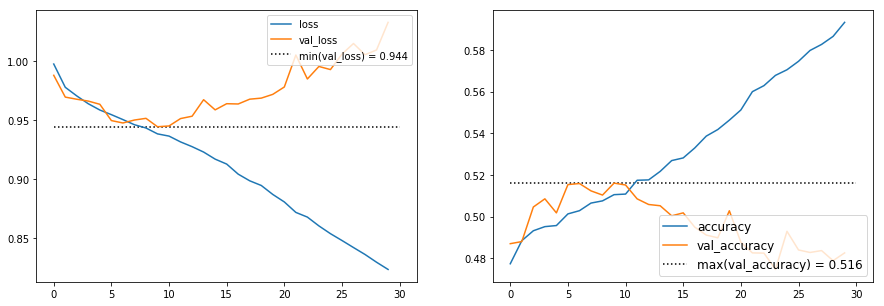

In [26]:
histplot(history)

In [27]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)
prediction = np.array(prediction)

In [30]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        result.append(2)
result = np.array(result)

result_translate = ['Compt', 'Phot', 'Phot like']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

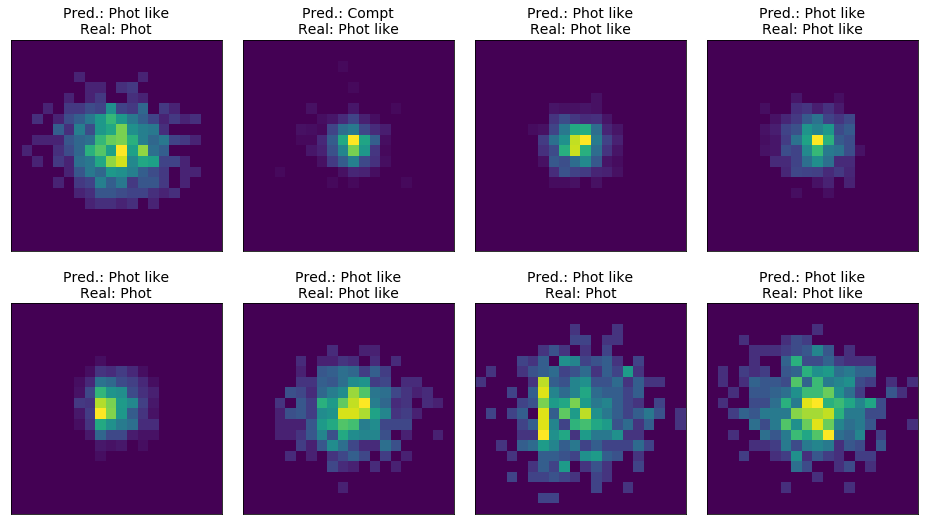

In [31]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [32]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
4769 of total 10000 ---> 47.69 %
------------------------------


In [39]:
tot_true_phot      = np.sum(y_test==1)/100
tot_true_compt     = np.sum(y_test==0)/100
tot_true_phot_like = np.sum(y_test==2)/100
print('True phot      labeled as   phot    --->  ' , int(np.round(np.sum(result[y_test==1]==1)/tot_true_phot)), '%')
print('True phot      labeled as   compt   --->   ', int(np.round(np.sum(result[y_test==1]==0)/tot_true_phot)), '%')
print('True phot      labeled as phot_like --->  ', int(np.round(np.sum(result[y_test==1]==2)/tot_true_phot)), '%')
print('True compt     labeled as   compt   --->  ', int(np.round(np.sum(result[y_test==0]==0)/tot_true_compt)), '%')
print('True compt     labeled as   phot    --->   ', int(np.round(np.sum(result[y_test==0]==1)/tot_true_compt)), '%')
print('True compt     labeled as phot_like --->  ', int(np.round(np.sum(result[y_test==0]==2)/tot_true_compt)), '%')
print('True phot_like labeled as phot_like --->  ' , int(np.round(np.sum(result[y_test==2]==2)/tot_true_phot_like)), '%')
print('True phot_like labeled as   phot    --->  ', int(np.round(np.sum(result[y_test==2]==1)/tot_true_phot_like)), '%')
print('True phot_like labeled as   compt   --->  ', int(np.round(np.sum(result[y_test==2]==0)/tot_true_phot_like)), '%')

True phot      labeled as   phot    --->   34 %
True phot      labeled as   compt   --->    4 %
True phot      labeled as phot_like --->   62 %
True compt     labeled as   compt   --->   39 %
True compt     labeled as   phot    --->    7 %
True compt     labeled as phot_like --->   54 %
True phot_like labeled as phot_like --->   67 %
True phot_like labeled as   phot    --->   13 %
True phot_like labeled as   compt   --->   20 %
